# Predicting Blood Donations


### **Contents**

---

* [**1. Importing Packages**](#1.-Importing-Packages)
* [**2. Importing Blood Donations Dataset**](#2.-Importing-Blood-Donations-Dataset)
* [**3. Target Feature Considerations**](#3.-Target-Feature-Considerations)
* [**4. Splitting into Training and Testing Sets**](#4.-Splitting-into-Training-and-Testing-Sets)
* [**5. Exploring the Dataset**](#5.-Exploring-the-Dataset)
* [**6. Evaluation Metric**](#6.-Evaluation-Metric)
* [**7. Selecting the Algorithms**](#7.-Selecting-the-Algorithms)
* [**8. Optimising the Hyper Parameters**](#8.-Optimising-the-Hyper-Parameters)
* [**9. Evaluating the Test Set**](#9.-Evaluating-the-Test-Set)
* [**10. Evaluating the Full Set**](#10.-Evaluating-the-Full-Set)
* [**11. Conclusions**](#11.-Conclusions)

---

## 1. Importing Packages
---

In [1]:
# File system management.
import os

# Numpy and pandas for data analysis and manipulation.
import numpy as np
import pandas as pd

# Matplotlib pyplot and seabourne for plotting
import matplotlib.pyplot as plt
# Seabourne for visualization
import seaborn as sns
sns.set_style('white')

# Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Sklearn importing folding methods method
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# Suppress deprecation warnings
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Importing cross validation grid search
from sklearn.grid_search import GridSearchCV

## 2. Importing Blood Donations Dataset
---

In [2]:
# Setting the directory
os.chdir('C:/Users/Jake Cherrie/Documents/Projects/Technical Evaluation Case Study')
# Viewing the contained items
os.listdir('.')

['.ipynb_checkpoints',
 'Case_Study_2_Blood_Donations_Data - Sheet1.csv',
 'Case_Study_2_Blood_Donations_Data.xlsx',
 'Data_Scientist_Case_Study_2_Instructions.odt',
 'Predicting Blood Donations.ipynb']

In [3]:
# Importing as pandas dataframe and displaying the top 5 entries of the blood donations dataset
blood_donations_df = pd.read_excel('Case_Study_2_Blood_Donations_Data.xlsx')
blood_donations_df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in May 2018
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 3. Target Feature Considerations
---

### A penny for my thoughts...

Reading the description of the target variable "...to create a model which will predict the likelihood of a donor donating again from the given data set" initially, makes me think we are looking at an open ended timeframe for donating again (e.g. a prediction over the remainder of their lives). But given some of the limitations in the dataset which include: not knowing the dates of each donation; a maximum period since the first donation of 98 months (~8 years); and not being given the actual dates of each past donation it would probably be very difficult and inaccurate to model the probability that they give blood again over their lifetimes. 
Secondly, I considered trying to define a reasonable timelso to define a period over which, if they are to donate again, they are statically likely to have done so by that point (a satisfactory confidence level would depend on the dataset). This would require either some outside knowledge or analysis of the distribution of donations over time. For the purposes of this tech eval I'm going to avoid looking into external data (te keep the scope of the problem reasonable) and the provided data would make the required analysis again very difficult and inaccurate).
I'm therefore choosing to use a target variable as the probability that donors will donate in the next blood drive month (Where the idea of blood drive months is explained below when exploring the 'Recency (months)' and 'Time (months)' features). 
Given that the 'blood drive months' do not occur at regular intervals I'm going to make the assumption that the profile of donations in may 2018 is a reasonable approximation of donations in any blood drive month.

Basically I'm using the feature 'whether he/she donated blood in May 2018' as my target variable.

## 4. Splitting into Training and Testing Sets
---

In [4]:
train, test = train_test_split(blood_donations_df, test_size=0.20, random_state=42)

###### Thoughts:
Although, I will use cross-validation when training the algorithms to maintain data size which in theory provides fair evaluation of the models performance, there will still be a number of decisions made in the data exploration and potential feature engineering and model optimisation which may be biased by knowing the full dataset. Therefore the creation of an initial training set will provide a true test of the models ability to generalise. (Given the limitations on data size in this case it might hinder overall performance but in principle it's a preferable method).

## 5. Exploring the Dataset
---

In [5]:
# Quick overview of the features
train.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in May 2018
count,598.000000,598.000000,598.000000,598.000000,598.000000
mean,9.536789,5.638796,1409.698997,34.891304,0.235786
std,8.330153,6.036736,1509.183915,24.849832,0.424844
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


###### Thoughts:
One point of note is that the target variable has a mean value of 0.238 so a base accuracy of 0.764 can be obtained by predicting no one will donate blood.

#### Exploring the “Total Volume Donated (c.c.)”  feature

In [6]:
# Checking the claim that '“Total Volume Donated (c.c.)” (Monetary) is exactly proportional to the 
# “Number of Donations” (Frequency) with Monetary = 250 * Frequency'
(train['Monetary (c.c. blood)']/train['Frequency (times)']).describe()

count    598.0
mean     250.0
std        0.0
min      250.0
25%      250.0
50%      250.0
75%      250.0
max      250.0
dtype: float64

In [7]:
# As the claim is correct I'm dropping the feature 'Monetary (c.c. blood)' as it contains no additional information
# (100% Correlated with 'Monetary (c.c. blood)')
train = train.drop(['Monetary (c.c. blood)'], axis=1)
test = test.drop(['Monetary (c.c. blood)'], axis=1)
blood_donations_df = blood_donations_df.drop(['Monetary (c.c. blood)'], axis=1)

#### Exploring the 'Recency (months)' feature

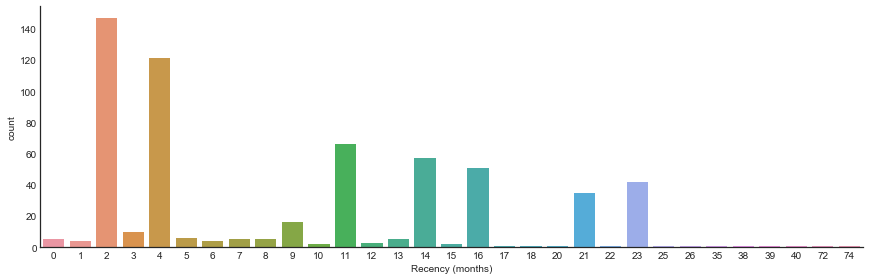

In [8]:
# Quick look at behaviour
sns.factorplot('Recency (months)', data = train, kind='count', size=4, aspect=3)

###### Thoughts: 
Over the past 2 years there seems to be some semblance of a seasonal donation cycle; where specific months year on year show significant spikes.
Significant spikes in recency in 16 (Jan2017), 14 (Mar2017) which line up spikes a year later 4 (Jan2018), 2 (Mar2018).
Assuming that 0 represents people who donated twice in May 2018 but not on the 31st, this doesn't line up with the pattern as (May2018) which with 23.7968% of 748 = 178 would represent a significant spike but 12 (May2017) wouldn't (unless there was some sort of offset here and the're a month or even a day earlier then the previous year?).

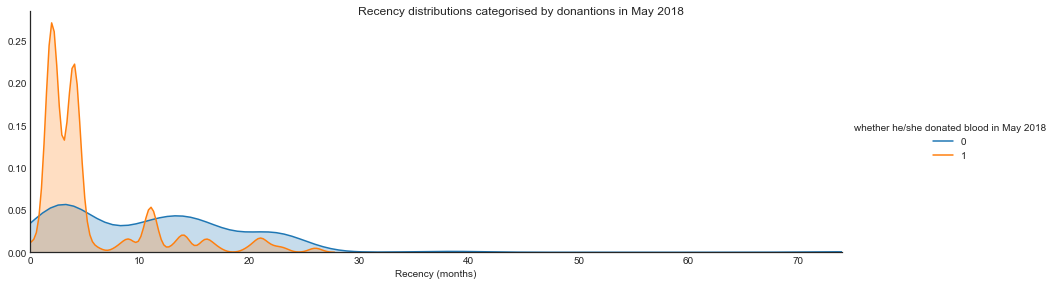

In [9]:
# Plotting the distributions of the recency against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', size=4, aspect=3)
recency.map(sns.kdeplot, 'Recency (months)', shade= True)
recency.set(xlim=(0 , train['Recency (months)'].max()))
recency.fig.suptitle('Recency distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
There is a far more significant ratio of donations to non-donations in may (orange to blue distributions) for people who donated in 4 and 16 (Jan) or 2 and 14 (Mar) Then people who donated outside of the spikes (which I'm assuming represent blood drives) then those who donated at other times. 
There also seems to be an overall decreasing trend for donations in (May2018) by overall recency.

#### Exploring the 'Time (months)' (Months since First Donation) feature

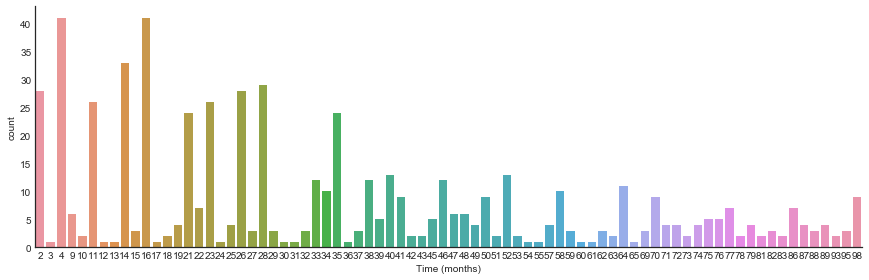

In [10]:
sns.factorplot('Time (months)', data = train, kind='count', size=4, aspect=3)

###### Thoughts: 
Here we can see more of the spikes which I'm assuming represent blood drive months

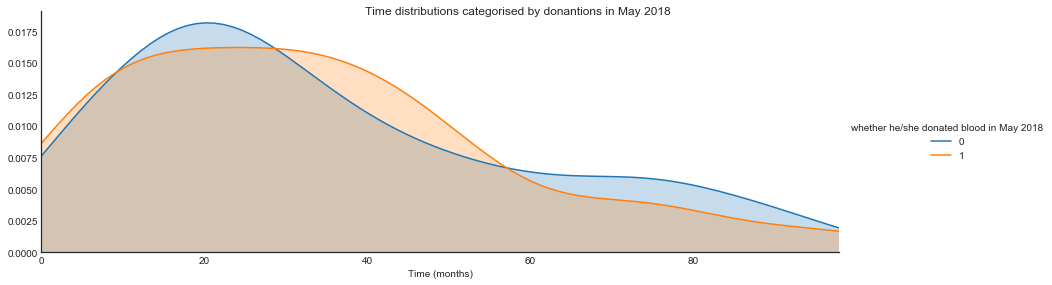

In [11]:
# Plotting the distributions of the time against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', size=4, aspect=3)
recency.map(sns.kdeplot, 'Time (months)', shade= True)
recency.set(xlim=(0 , train['Time (months)'].max()))
recency.fig.suptitle('Time distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
The distribution shows a relationship that is not immediately intuitive with 4 distinct sections. 24 to 50 months seems to be the most likely to donate again, 0-12 the second most, 50+ the least, 12-23 is the second least. This indicates that, when the time is viewed in isolation, it has a non-monotonic relationship with the target; as such, I will need to be carefull treating the feature as numeric when using algorithms such as logistic regressions. (binning features in these methods could be used to adjust in such cases).

#### Exploring the 'Frequency (times)' feature

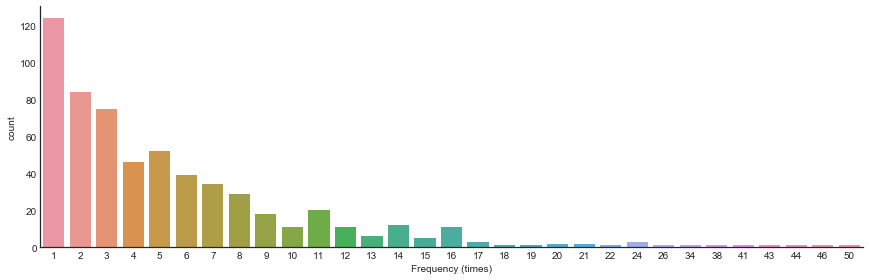

In [12]:
sns.factorplot('Frequency (times)', data = train, kind='count', size=4, aspect=3)

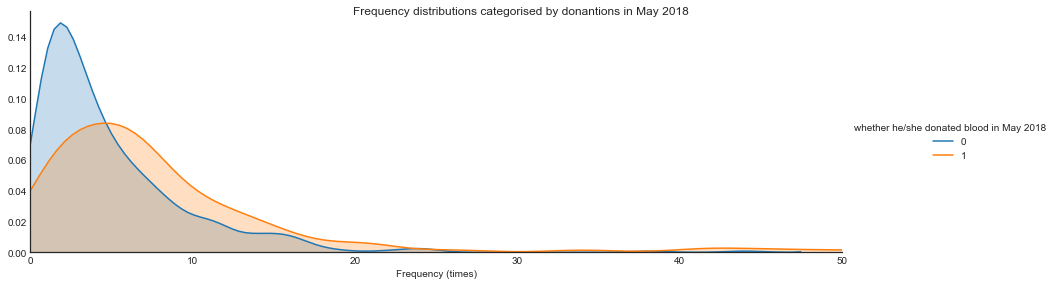

In [13]:
# Plotting the distributions of the frequency against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', size=4, aspect=3)
recency.map(sns.kdeplot, 'Frequency (times)', shade= True)
recency.set(xlim=(0 , train['Frequency (times)'].max()))
recency.fig.suptitle('Frequency distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
Advantageous to have donated more than 5 times but relatively stable after that (hard to distinguish after 25 due to low volumes).

#### Creating and exploring a rate of donations feature

In [14]:
# Defining new feature 'Rate as the average number of donations per month
train['Rate (months)'] = train['Frequency (times)']/train['Time (months)']
train['Rate (months)'] = train['Rate (months)'].round(2)

test['Rate (months)'] = test['Frequency (times)']/test['Time (months)']
test['Rate (months)'] = test['Rate (months)'].round(2)

blood_donations_df['Rate (months)'] = blood_donations_df['Frequency (times)']/blood_donations_df['Time (months)']
blood_donations_df['Rate (months)'] = blood_donations_df['Rate (months)'].round(2)

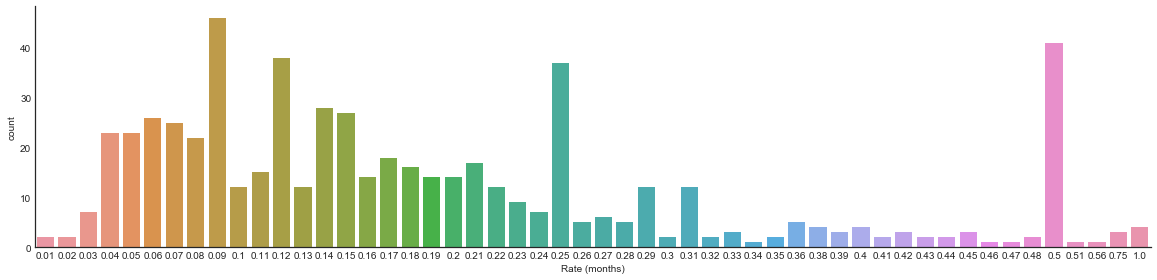

In [15]:
sns.factorplot('Rate (months)', data = train, kind='count', size=4, aspect=4)

###### Thoughts:
Higher rates noted at 0.25 and 0.5 (not sure if this is useful at this stage also, it might be worth noting that donor rates over 0.5 seems unsafe).

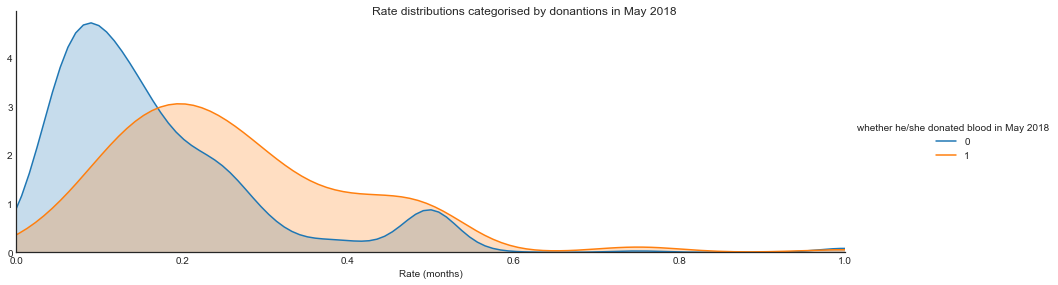

In [16]:
# Plotting the distributions of the rate against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', size=4, aspect=3)
recency.map(sns.kdeplot, 'Rate (months)', shade= True)
recency.set(xlim=(0 , train['Rate (months)'].max()))
recency.fig.suptitle('Rate distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
For the most part this follows an expected trend except for a spike in non-donors with a rate of once every two months.
This could be people who donate once every two months and for some reason may is an off month or simply a chance spike. This could use further investigation but for now I'm assuming that the decrease in the ratio of people who donated in May 2018 and donate on average every two months is a chance spike.

#### Creating and exploring a 'On Schedule' feature

In [17]:
# Defining new feature 'On Schedule' as the product of recency to rate (this should quantify if they are currently 
# behind their usual schedule)
train['On Schedule'] = train['Recency (months)']*train['Rate (months)']
train['On Schedule'] = train['On Schedule'].round(1)

test['On Schedule'] = test['Recency (months)']*test['Rate (months)']
test['On Schedule'] = test['On Schedule'].round(1)

blood_donations_df['On Schedule'] = blood_donations_df['Recency (months)']*blood_donations_df['Rate (months)']
blood_donations_df['On Schedule'] = blood_donations_df['On Schedule'].round(1)

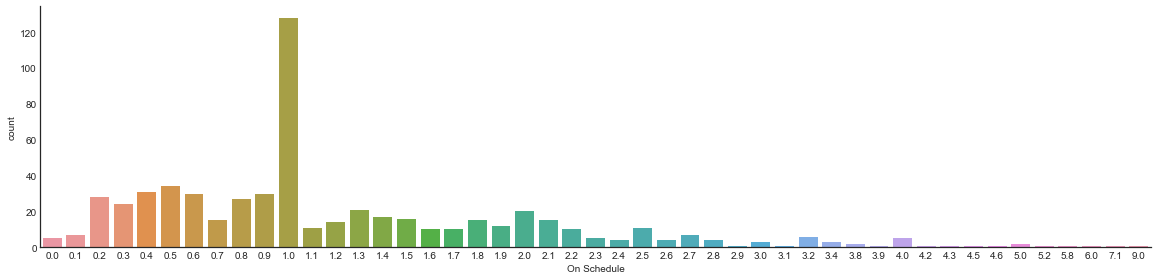

In [18]:
sns.factorplot('On Schedule', data = train, kind='count', size=4, aspect=4)

###### Thoughts:
A large spike at 1 (I think this might be due to people who only have 1 prior donation in the prior blood drive).

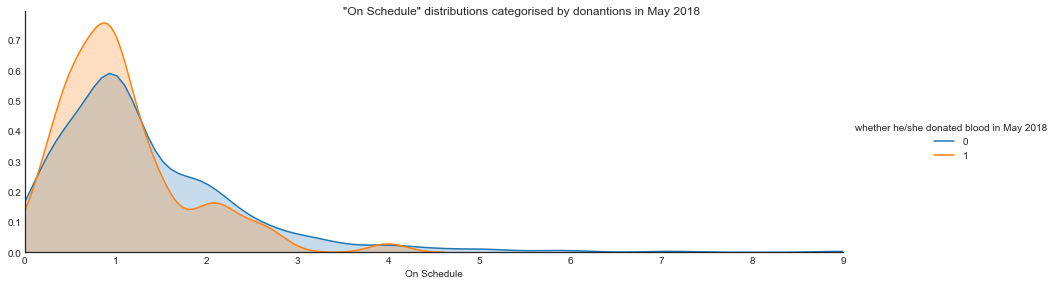

In [19]:
# Plotting the distributions of the rate against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', size=4, aspect=3)
recency.map(sns.kdeplot, 'On Schedule', shade= True)
recency.set(xlim=(0 , train['On Schedule'].max()))
recency.fig.suptitle('"On Schedule" distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
There seems to be a reasonably strong relationship for donations roughly on schedule

#### Exploring pair plots and feature correlations

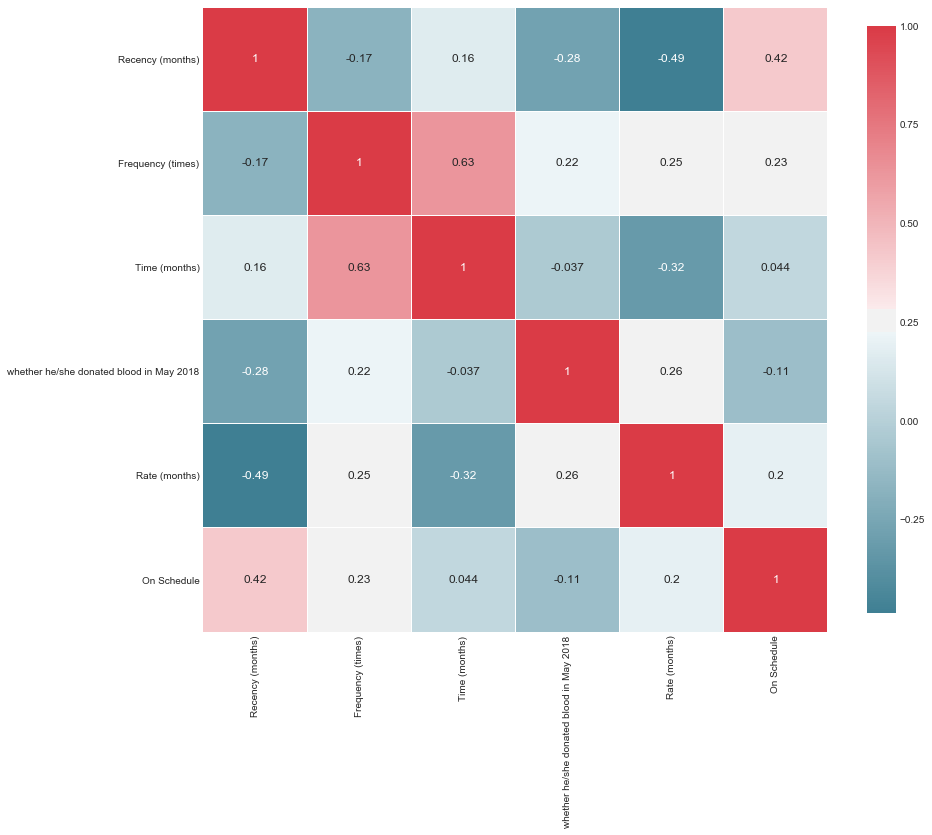

In [20]:
# Correlation heatmap of dataset
corr_plt , ax = plt.subplots(figsize =(14, 12))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

corr_plt = sns.heatmap(
    train.corr(), 
    cmap = colormap,
    square=True, 
    cbar_kws={'shrink':.9 }, 
    ax=ax,
    annot=True, 
    linewidths=0.1,vmax=1.0, linecolor='white',
    annot_kws={'fontsize':12 }
)

##### Thoughts:
All correlations are below 0.5 the highest abs values noted is rate and recency. This is interesting given rate isn’t derived from recency

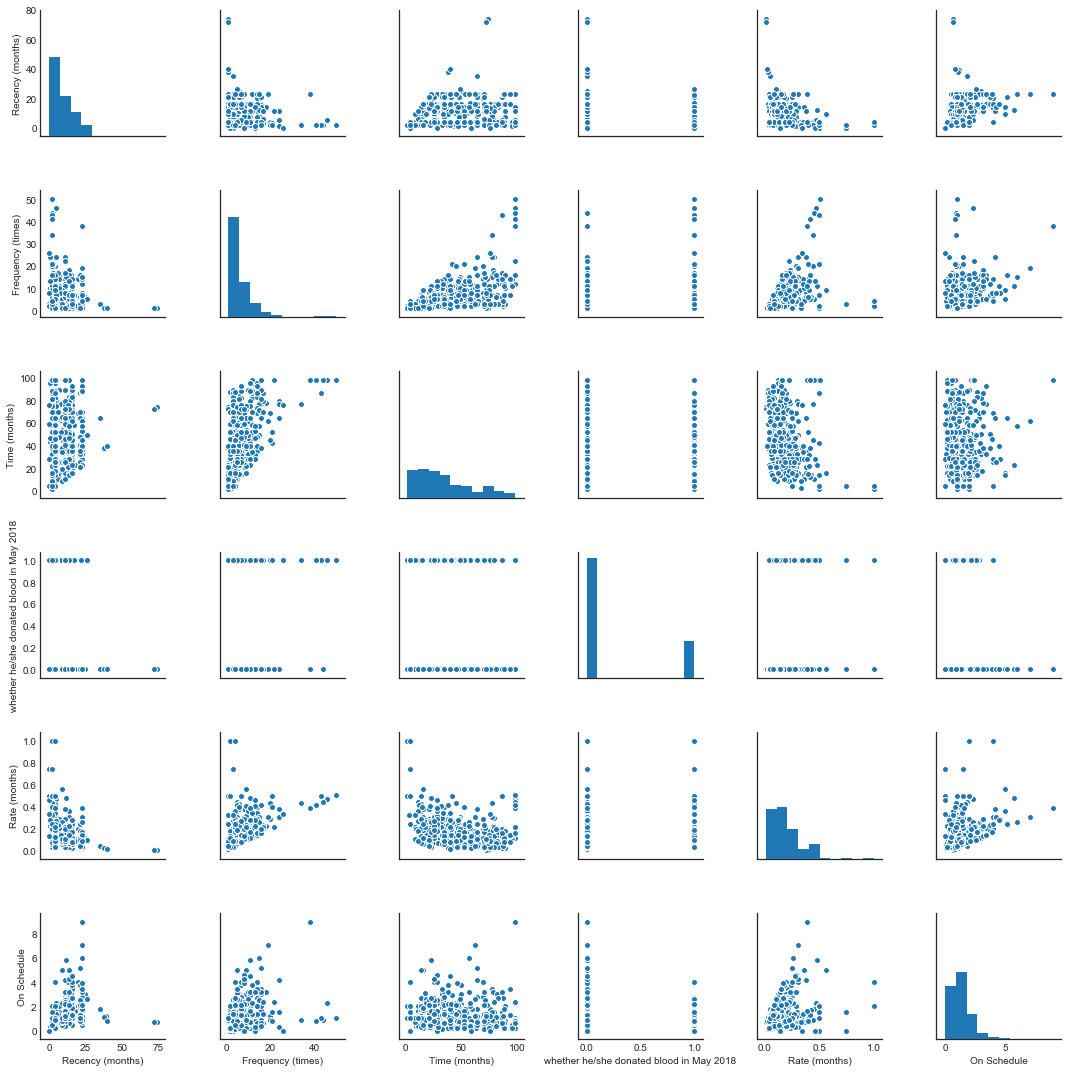

In [21]:
sns.pairplot(train)

#### Dimensionality Reduction:
Due to the simplicity of the dataset (and low correlations) I won't explore the possibility of dimensionality reduction for this evaluation.

#### Normalisation:
I won't explore normalising features in this eval but I don't expect it to be a large factor in the algorithms as most features are within an order of magnitude.


#### Additional Engineered Features:
Given the limited time I spent investigating I assume that there other useful insights in various combination or exponential/log features. For the purpose of this eval I will not investigate these further.

## 6. Evaluation Metric
---

###### Thoughts:
Considering potential evaluation metrics the simplest metric would be the accuracy metric although as the target variable is somewhat unbalanced so a method that leans towards predicting non-donors may be favored (this could be asses with with precision-recall analysis). A better metric in this case could be the gini or area under the ROC which would measure the information or ordering of the model. The root-mean-squared-error (RMSE) could be used to make sure that large discrepancies are more heavily penalised then simply using the accuracy (reducing the effect of the imbalance).

In this case I'm going to use the Log-Loss as my primary metric while keeping an eye on accuracy and the area under the ROC. This was basically driven by a bit of research into the problem which indicated that there is an online competition for this (or atleast a very similar dataset) that uses this an an evaluation metric. This metric is described as 'This function gives a maximum penalty when an extreme error is made, that is when the actual value is 0 and the predicted value is 1, or vice versa, since it could give an infinity score' a more extreme way of penalising severe errors

## 7. Selecting the Algorithms
---

In [22]:
# Function for displaying feature importance
def display_importances(fld_imp, mdl_nme):
    cols = fld_imp[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = fld_imp.loc[fld_imp.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features (avg over folds)')
    plt.tight_layout()

In [23]:
blood_donations_df.head()

,Recency (months),Frequency (times),Time (months),whether he/she donated blood in May 2018,Rate (months),On Schedule
0,2,50,98,1,0.51,1.0
1,0,13,28,1,0.46,0.0
2,1,16,35,1,0.46,0.5
3,2,20,45,1,0.44,0.9
4,1,24,77,0,0.31,0.3


In [24]:
def model_fit(mdl, mdl_nme = '', n_fld = 5, dbg = True):   
    print(mdl_nme)
    # K fold validation
    fld = StratifiedKFold(n_splits = n_fld, shuffle=True, random_state = 3)
    
    # List of feature columns
    fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]
    
    # Initializing Variables
    prd = np.zeros(train[fts].shape[0])
    sub_prd = np.zeros(blood_donations_df[fts].shape[0])
    sub_prd_tst = np.zeros(test[fts].shape[0])
    fts_imp = pd.DataFrame()
    acc = 0
    auc = 0
    log_los = 0
    log_los_tot = 0
    
    for n_fold, (trn_idx, vld_idx) in enumerate(fld.split(train[fts], train['whether he/she donated blood in May 2018'])):
        trn_X, trn_y = train[fts].iloc[trn_idx], train['whether he/she donated blood in May 2018'].iloc[trn_idx]
        vld_X, vld_y = train[fts].iloc[vld_idx], train['whether he/she donated blood in May 2018'].iloc[vld_idx]
        
        # Fit the model
        mdl.fit(trn_X, trn_y)
        
        if hasattr(mdl, 'predict_proba'):
            prd[vld_idx] = mdl.predict_proba(vld_X)[:, 1]
            
            # Appling the fit to the prediction set
            sub_prd += mdl.predict_proba(blood_donations_df[fts])[:, 1]/fld.n_splits
            # Appling the fit to the prediction set
            sub_prd_tst += mdl.predict_proba(test[fts])[:, 1]/fld.n_splits
            # Outputting the AUC
            auc += roc_auc_score(vld_y, prd[vld_idx])/fld.n_splits
            log_los = log_loss(vld_y, mdl.predict_proba(vld_X)[:, 1])
            log_los_tot += log_los/fld.n_splits
                
        # Outputting statistics
        print('Fold %2d acc : %.6f' % (n_fold + 1, mdl.score(vld_X, vld_y)))
        print('Fold %2d log_loss : %.6f' % (n_fold + 1, log_los))
        acc += mdl.score(vld_X, vld_y) / fld.n_splits
        
        fld_imp = pd.DataFrame()
        fld_imp["feature"] = fts
        if hasattr(mdl, 'feature_importances_'):
            fld_imp["importance"] = mdl.feature_importances_
        elif hasattr(mdl, 'coef_'):
            fld_imp["importance"] = abs(list(np.std(trn_X, 0))*mdl.coef_[0])
        else:
            fld_imp["importance"] = None
        fld_imp["fold"] = n_fold + 1
        fts_imp = pd.concat([fts_imp, fld_imp], axis=0)
    
    print('Average AUC over folds: %.6f' % auc)
    print('Accuracy : %.6f' % acc)
    print('Average log_loss over folds: %.6f' % log_los)

    # Display Importances and save prediction
    if dbg == False:
        # Displaying Feature Importance
        if (hasattr(mdl, 'feature_importances_') | hasattr(mdl, 'coef_')):
            display_importances(fld_imp, mdl_nme)

    return sub_prd, sub_prd_tst, nme, log_los_tot

#### Initial look at a variety of classification algorithms

In [25]:
MLA = [
   # Ensemble Methods
   ensemble.AdaBoostClassifier(),
   ensemble.BaggingClassifier(),
   ensemble.ExtraTreesClassifier(),
   ensemble.GradientBoostingClassifier(),
   ensemble.RandomForestClassifier(),
       
   # Boosted Tree Classifiers
   XGBClassifier(),  
   LGBMClassifier(),

   # Gaussian Processes
   gaussian_process.GaussianProcessClassifier(),
   
   # GLM
   linear_model.LogisticRegression(),
   linear_model.PassiveAggressiveClassifier(),
   linear_model.RidgeClassifierCV(),
   linear_model.Perceptron(),
   
   # Navies Bayes
   naive_bayes.BernoulliNB(),
   naive_bayes.GaussianNB(),
   
   # Nearest Neighbor
   neighbors.KNeighborsClassifier(),
   
   # SVM
   svm.SVC(probability=True),
   
   # Trees    
   tree.DecisionTreeClassifier(),
   tree.ExtraTreeClassifier(),
   
   # Discriminant Analysis
   discriminant_analysis.LinearDiscriminantAnalysis(),
   discriminant_analysis.QuadraticDiscriminantAnalysis()
   ]

mdl_dta = pd.DataFrame(columns = ['Algorithm', 'Log Loss'])
row_index = 0

# Applying the algorithms using 5 folds (Not exploring more at this stage) 
for alg in MLA:
   nme = alg.__class__.__name__
   prd, prd_tst, nme, loss = model_fit(alg, mdl_nme = nme, n_fld = 5)
   mdl_dta.loc[row_index, 'Algorithm'] = nme
   mdl_dta.loc[row_index, 'Log Loss'] = loss
   row_index += 1


AdaBoostClassifier
Fold  1 acc : 0.760331
Fold  1 log_loss : 0.671938
Fold  2 acc : 0.766667
Fold  2 log_loss : 0.664424
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.669531
Fold  4 acc : 0.798319
Fold  4 log_loss : 0.671603
Fold  5 acc : 0.773109
Fold  5 log_loss : 0.675276
Average AUC over folds: 0.707565
Accuracy : 0.772626
Average log_loss over folds: 0.675276
BaggingClassifier
Fold  1 acc : 0.743802
Fold  1 log_loss : 2.166226
Fold  2 acc : 0.758333
Fold  2 log_loss : 1.602963
Fold  3 acc : 0.781513
Fold  3 log_loss : 2.128394
Fold  4 acc : 0.789916
Fold  4 log_loss : 1.290734
Fold  5 acc : 0.815126
Fold  5 log_loss : 2.102834
Average AUC over folds: 0.688880
Accuracy : 0.777738
Average log_loss over folds: 2.102834
ExtraTreesClassifier
Fold  1 acc : 0.743802
Fold  1 log_loss : 4.619488
Fold  2 acc : 0.700000
Fold  2 log_loss : 4.068683
Fold  3 acc : 0.756303
Fold  3 log_loss : 3.282466
Fold  4 acc : 0.756303
Fold  4 log_loss : 2.938916
Fold  5 acc : 0.747899
Fold  5 log_loss : 2.12

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold  1 acc : 0.305785
Fold  1 log_loss : 0.000000
Fold  2 acc : 0.808333
Fold  2 log_loss : 0.000000
Fold  3 acc : 0.756303
Fold  3 log_loss : 0.000000
Fold  4 acc : 0.722689
Fold  4 log_loss : 0.000000
Fold  5 acc : 0.470588
Fold  5 log_loss : 0.000000
Average AUC over folds: 0.000000
Accuracy : 0.612740
Average log_loss over folds: 0.000000
BernoulliNB
Fold  1 acc : 0.752066
Fold  1 log_loss : 0.560903
Fold  2 acc : 0.766667
Fold  2 log_loss : 0.540642
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.540282
Fold  4 acc : 0.764706
Fold  4 log_loss : 0.545780
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.555540
Average AUC over folds: 0.503870
Accuracy : 0.760889
Average log_loss over folds: 0.555540
GaussianNB
Fold  1 acc : 0.702479
Fold  1 log_loss : 0.715767
Fold  2 acc : 0.758333
Fold  2 log_loss : 0.527563
Fold  3 acc : 0.781513
Fold  3 log_loss : 0.581621
Fold  4 acc : 0.739496
Fold  4 log_loss : 0.522486
Fold  5 acc : 0.714286
Fold  5 log_loss : 0.926552
Average AUC over folds: 0.7266

Text(0,0.5,'Algorithm')

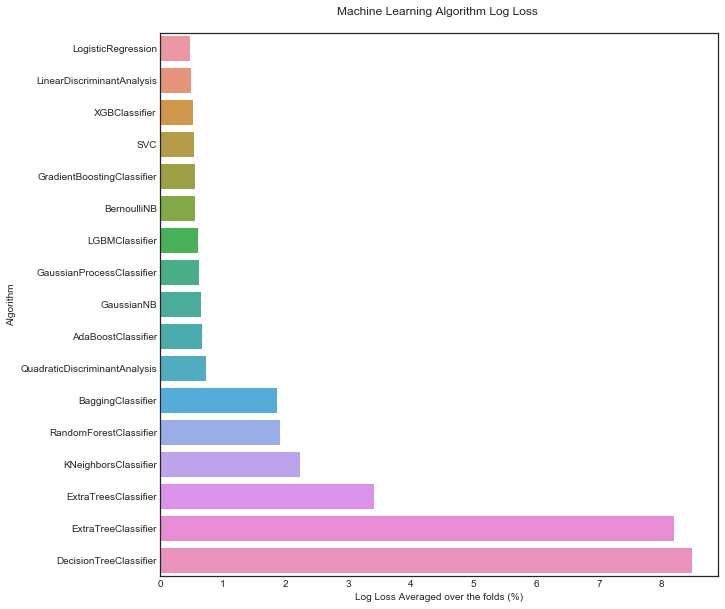

In [26]:
# Plotting algoritims log loss averaged across the folds
plt.figure(figsize=(10,10))
sns.barplot(x='Log Loss', y = 'Algorithm', data = mdl_dta[mdl_dta['Log Loss']>0].sort_values(by='Log Loss'))
plt.title('Machine Learning Algorithm Log Loss \n')
plt.xlabel('Log Loss Averaged over the folds (%)')
plt.ylabel('Algorithm')

##### Thoughts:
Some of the methods do not have a predict_proba method and so couldn't produce a log_loss or AUC metric and no further investigation was done at this point. While it would be worth investigating these methods in more detail (and possibly a wider range of methods) for the purposes of this evaluation I will move forwards with some of the better performing methods including: Linear Discriminant Analysis with a log loss of 0.524955; the Support Vector Classification with an radial basis function = 0.517178; the Logistic Regression = 0.529799; and the XGBClassifier = 0.551418.

## 8. Optimising the Hyper Parameters
---

##### Thoughts:
Using a basic grid search without a significant amount of time investigating paramaters. The small size of the data means that more complex bayesian optimization methods are probably unnecessary.

#### Linear Discriminant Analysis

Linear Discriminant Analysis
Fold  1 acc : 0.735537
Fold  1 log_loss : 0.555312
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.430884
Fold  3 acc : 0.806723
Fold  3 log_loss : 0.435439
Fold  4 acc : 0.781513
Fold  4 log_loss : 0.470212
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.524955
Average AUC over folds: 0.743149
Accuracy : 0.774348
Average log_loss over folds: 0.524955


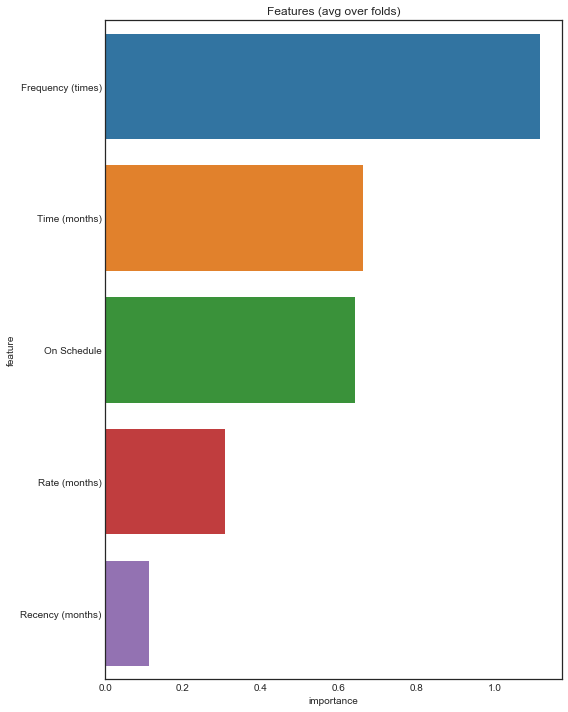

In [27]:
# Linear Discriminant Analysis is closed form and therefore, has no hyper paramaters
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
prd, prd_tst, nme, acc = model_fit(LDA, 'Linear Discriminant Analysis' , n_fld = 5, dbg=False)

#### Support Vector Classifier

In [28]:
# Parameter grid for XGBoost
params =[{
        'gamma': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2],
        'kernel': ['linear']},
         {
        'C': [0.1, 0.5, 0.8, 1, 1.2, 1.4, 1.6],
        'gamma': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2],
        'kernel': ['rbf']
        }]

In [29]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search2 = GridSearchCV(estimator = svm.SVC(probability=True, C=0.1, gamma=1, kernel='rbf'), 
                        param_grid = params, scoring='log_loss', n_jobs=4, iid=False, cv=5)

search2.fit(train[fts],train['whether he/she donated blood in May 2018'])

search2.best_params_, search2.best_score_

({'C': 1.6, 'gamma': 0.01, 'kernel': 'rbf'}, -0.5044873215545169)

Support Vector Classifier
Fold  1 acc : 0.760331
Fold  1 log_loss : 0.532956
Fold  2 acc : 0.783333
Fold  2 log_loss : 0.479428
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.541485
Fold  4 acc : 0.764706
Fold  4 log_loss : 0.484580
Fold  5 acc : 0.764706
Fold  5 log_loss : 0.523966
Average AUC over folds: 0.731589
Accuracy : 0.767556
Average log_loss over folds: 0.523966


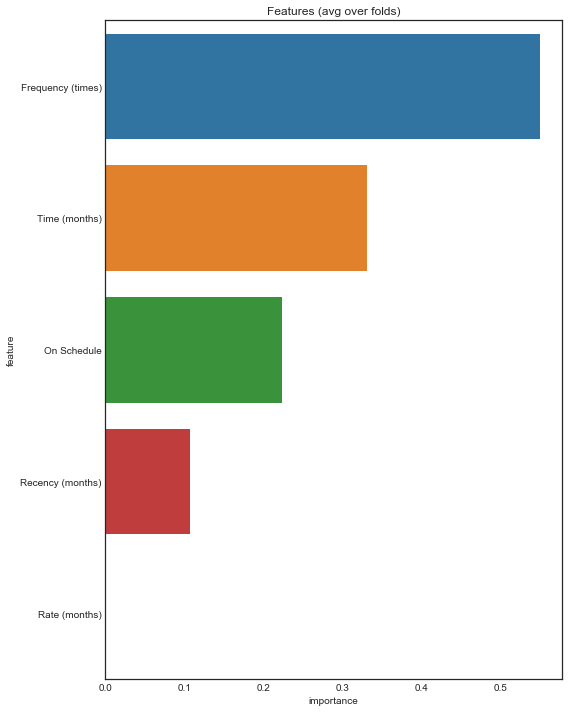

In [30]:
SVC = svm.SVC(probability=True, gamma=1, kernel='linear')
prd, prd_tst, nme, acc = model_fit(SVC, 'Support Vector Classifier' , n_fld = 5, dbg=False)
# Note that I expect to see a decrease going to the Average log_loss over folds from the log loss in the optimisation

#### Logistic Regression

In [31]:
# Parameter grid for Logistic Regression
params = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

In [32]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search3 = GridSearchCV(estimator = linear_model.LogisticRegression(C=1), 
                        param_grid = params, scoring='log_loss', n_jobs=4, iid=False, cv=5)

search3.fit(train[fts],train['whether he/she donated blood in May 2018'])

search3.best_params_, search3.best_score_

({'C': 0.1}, -0.4852359371309077)

Logistic Regression
Fold  1 acc : 0.743802
Fold  1 log_loss : 0.536992
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.426624
Fold  3 acc : 0.806723
Fold  3 log_loss : 0.430054
Fold  4 acc : 0.781513
Fold  4 log_loss : 0.456381
Fold  5 acc : 0.764706
Fold  5 log_loss : 0.528338
Average AUC over folds: 0.747223
Accuracy : 0.777682
Average log_loss over folds: 0.528338


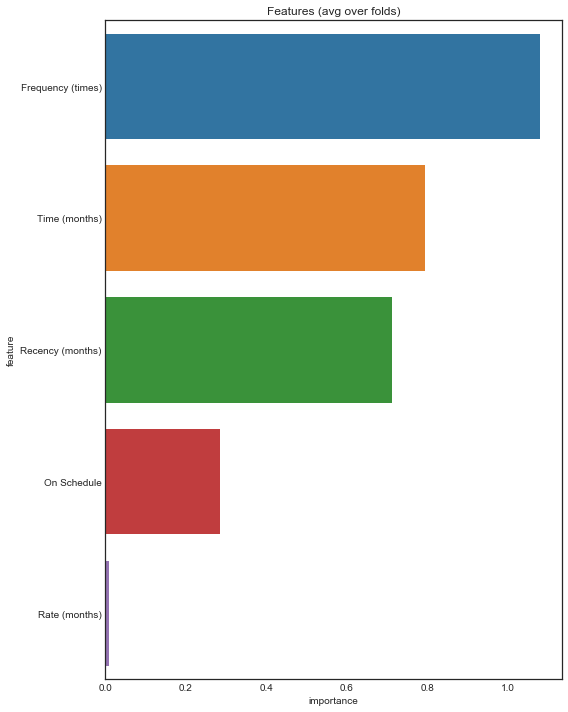

In [33]:
log_reg = linear_model.LogisticRegression(C=0.1)
prd, prd_tst, nme, acc = model_fit(log_reg, 'Logistic Regression' , n_fld = 5, dbg=False)

#### XGBoost Classifier

In [34]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 2, 5, 8, 9, 10, 11, 15, 20],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 4, 6, 10],
        'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5]
        }

In [35]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, seed=42), 
                        param_grid = params, scoring='log_loss', n_jobs=4, iid=False, cv=5)

search1.fit(train[fts],train['whether he/she donated blood in May 2018'])

search1.best_params_, search1.best_score_

({'colsample_bytree': 0.8,
  'gamma': 4,
  'max_depth': 3,
  'min_child_weight': 2,
  'subsample': 0.8},
 -0.46249233785423155)

XGBClassifier
Fold  1 acc : 0.735537
Fold  1 log_loss : 0.556204
Fold  2 acc : 0.800000
Fold  2 log_loss : 0.430186
Fold  3 acc : 0.806723
Fold  3 log_loss : 0.448645
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.440762
Fold  5 acc : 0.781513
Fold  5 log_loss : 0.477703
Average AUC over folds: 0.754855
Accuracy : 0.779376
Average log_loss over folds: 0.477703


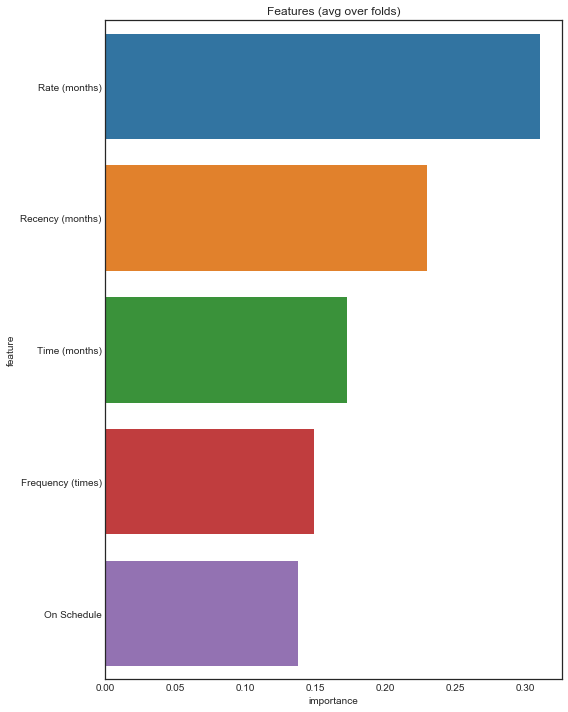

In [36]:
XGB = XGBClassifier(max_depth=3, min_child_weight=2, gamma=4, subsample=0.8, colsample_bytree=0.8, seed=42)
prd, prd_tst, nme, acc = model_fit(XGB, 'XGBClassifier' , n_fld = 5, dbg=False)

##### Thoughts:
Given that the XGB Classifier performed the best I will use it going forwards although it is worth noting that as the XGB is a fairly complex ensomble methos and the other methods are simplier to understand and more redialy auditable depending on how they predictions are to be used they may be more desirable. 

If pure performance is the goal when developing this model further the possibility of an ensemble of the above algaritims should be explored. Given the differences in feature importance they are likly not particularly correlated so this seems like a promising option. 

## 9. Evaluating the Test Set
---

In [37]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
Test_AUC = roc_auc_score(test['whether he/she donated blood in May 2018'], prd_tst)
prd_tst_bin = np.zeros(prd_tst.shape[0])
prd_tst_bin[prd_tst > 0.5] = 1
Test_accuracy = accuracy_score(test['whether he/she donated blood in May 2018'], prd_tst_bin)
Test_log_loss = log_loss(test['whether he/she donated blood in May 2018'], prd_tst)

print('AUC : %.6f' % Test_AUC)
print('Acc : %.6f' % Test_accuracy)
print('Log Loss : %.6f' % Test_log_loss)

AUC : 0.742645
Acc : 0.793333
Log Loss : 0.488059


## 10. Evaluating the Full Set
---

In [38]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
AUC = roc_auc_score(blood_donations_df['whether he/she donated blood in May 2018'], prd)
prd_bin = np.zeros(prd.shape[0])
prd_bin[prd > 0.5] = 1
Accuracy = accuracy_score(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
Log_loss = log_loss(blood_donations_df['whether he/she donated blood in May 2018'], prd)

print('AUROC : %.6f' % AUC)
print('Accuracy : %.6f' % Accuracy)
print('Log Loss : %.6f' % Log_loss)

AUROC : 0.802055
Accuracy : 0.811497
Log Loss : 0.437031


#### Refitting the model on the entire dataset (to maximise data for the final fit)

In [39]:
# Resetting main dataset and refitting the model based on the full set to maximise data (This assumes that as the test set showed the model didn't materially overfit)
blood_donations_df = pd.read_excel('Case_Study_2_Blood_Donations_Data.xlsx')
blood_donations_df = blood_donations_df.drop(['Monetary (c.c. blood)'], axis=1)

blood_donations_df['Rate (months)'] = blood_donations_df['Frequency (times)']/blood_donations_df['Time (months)']
blood_donations_df['Rate (months)'] = blood_donations_df['Rate (months)'].round(2)

blood_donations_df['On Schedule'] = blood_donations_df['Recency (months)']*blood_donations_df['Rate (months)']
blood_donations_df['On Schedule'] = blood_donations_df['On Schedule'].round(1)

train =  blood_donations_df
test = blood_donations_df

XGBClassifier
Fold  1 acc : 0.786667
Fold  1 log_loss : 0.493252
Fold  2 acc : 0.786667
Fold  2 log_loss : 0.501885
Fold  3 acc : 0.820000
Fold  3 log_loss : 0.428938
Fold  4 acc : 0.812081
Fold  4 log_loss : 0.502505
Fold  5 acc : 0.778523
Fold  5 log_loss : 0.474096
Average AUC over folds: 0.734974
Accuracy : 0.796787
Average log_loss over folds: 0.474096


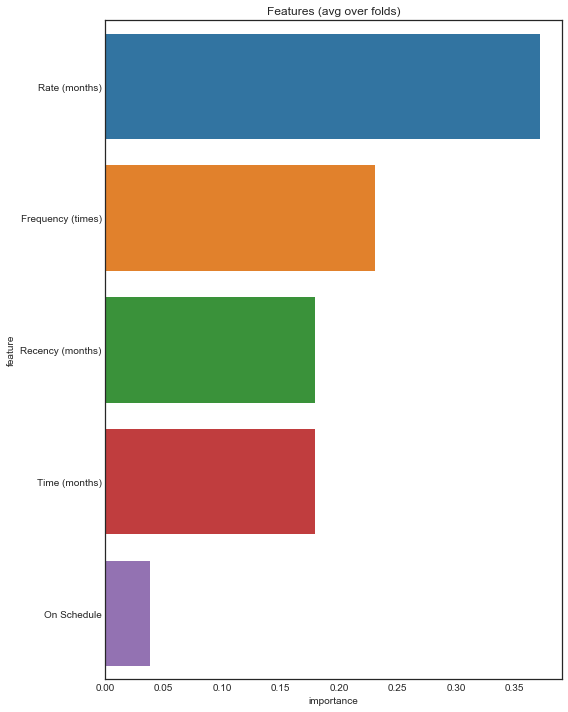

In [40]:
XGB = XGBClassifier(max_depth=3, min_child_weight=9, gamma=1, subsample=1, colsample_bytree=1, seed=42)
prd, prd_tst, nme, acc = model_fit(XGB, 'XGBClassifier', n_fld = 5, dbg=False)

In [41]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
AUC = roc_auc_score(blood_donations_df['whether he/she donated blood in May 2018'], prd)
prd_bin = np.zeros(prd.shape[0])
prd_bin[prd > 0.5] = 1
Accuracy = accuracy_score(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
Log_loss = log_loss(blood_donations_df['whether he/she donated blood in May 2018'], prd)

print('AUC : %.6f' % AUC)
print('Acc : %.6f' % Accuracy)
print('Log Loss : %.6f' % Log_loss)

AUC : 0.805697
Acc : 0.812834
Log Loss : 0.431892


#### Plotting the confusion matrix

In [42]:
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

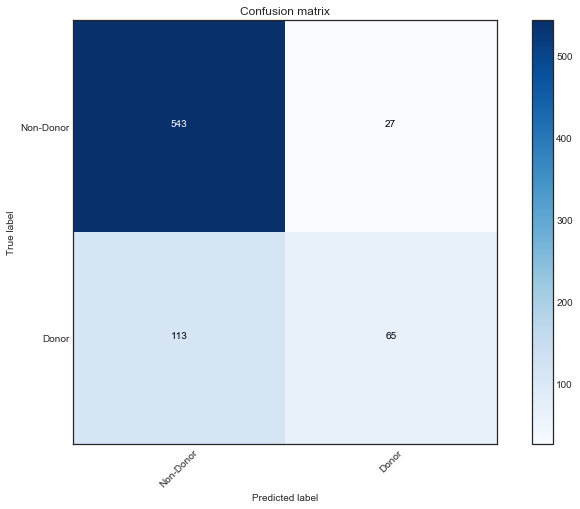

In [43]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
# np.set_printoptions(precision=2)

class_names = ['Non-Donor', 'Donor']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

##### Thoughts:
As expected with an ensemble method they tend to under-predict the more less class (donor). If this is not desirable other methods such as, logistic regression will give a more realistic split in the confusion matrix.

#### Plotting the ROC curve

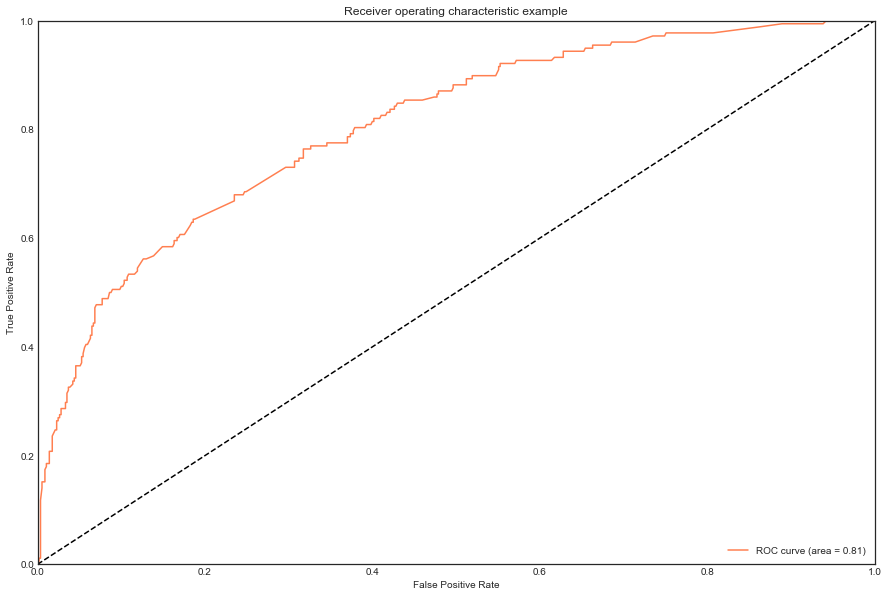

In [44]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(blood_donations_df['whether he/she donated blood in May 2018'], prd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

##### Thoughts:
Overall a strong ROC accross the board with no points of particular weakness.

## 11. Conclusions
---

The definition of the target variable used in this analysis is assumed to be donations made in the month of May 2018. This target only an approximation used to represent the likelihood of donating in a future month and depends on a range of factors including: is the month we aim to generalise too (is it a blood-drive month) and how long since the previous blood drive month. If the goal is to build a model to the open ended will they donate again this is probably a crude approximation at best and should be expected to significantly underestimate the probability.

That being said in relation to the assumed target variable the model produces, what seems to be a relativly robust set of statists when compaired to similar models uploaded as example answers to the compitition https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/. It produced a log loss of 0.43 a area under the receiver-operating-characteristic (AUROC) of 0.81 and an accuracy of 0.81 along with this, the ROC curve indicates that the models ability to discriminate is strong and stable across the entire range of probabilities. 

A limitation on the model can be identified in the confusion matrix if the purpose of the model is ever to be used to predict anything other then a single donor as the total number of predicted donors is significantly lower than the actual number of donors.

Although it is difficult to draw general conclusions from such a limited exploration of the dataset a number of insights can be gained.
There seems to be a very definite pattern of months with a significant number of donors and months with a limited number of donors. This patterns seems to 'roughly' repeat around the same times each year, for the past, few years but become noisy before this.
No standout algorithm was identified in this investigation with a range of different classifiers showing reasonable performance. As such the choice of algorithm may come down to other factors such as simplicity or stability.

I expect that there is room to improve on the models overall performance through further investigating and refining the engineered feature the algorithm. And significantly more room with a more indepth dataset.

---